In [1]:
import pandas as pd
import numpy as np

# Load the permeability data without specifying column names to inspect the data structure
csv_file_path = '//home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Clean Dataset/PERMnoheader_Krev.csv'
permeability_data = pd.read_csv(csv_file_path, header=None)

# Check how many columns are in the CSV
print(f"CSV contains {permeability_data.shape[1]} columns.")

# If the CSV contains 4 columns, assign names accordingly
if permeability_data.shape[1] == 4:
    permeability_data.columns = ['i', 'j', 'k', 'Facies']
else:
    # Handle the case where the column count does not match expectation
    raise ValueError(f"Unexpected number of columns in the CSV: {permeability_data.shape[1]}. Expected 4.")

# Force columns to numeric, setting errors='coerce' will replace non-numeric entries with NaN
permeability_data['i'] = pd.to_numeric(permeability_data['i'], errors='coerce')
permeability_data['j'] = pd.to_numeric(permeability_data['j'], errors='coerce')
permeability_data['k'] = pd.to_numeric(permeability_data['k'], errors='coerce')
permeability_data['Facies'] = pd.to_numeric(permeability_data['Facies'], errors='coerce')

# Drop rows with any NaN values (non-numeric entries or initial NaNs in the permeability column)
permeability_data = permeability_data.dropna()

# Convert indices to integers after cleaning
permeability_data['i'] = permeability_data['i'].astype(int)
permeability_data['j'] = permeability_data['j'].astype(int)
permeability_data['k'] = permeability_data['k'].astype(int)

# Replace -99 values in 'permeability' column with NaN for better handling of missing data
permeability_data['permeability'] = permeability_data['Facies'].replace(-99, np.nan)

# Get the max dimensions
max_i = permeability_data['i'].max() + 1
max_j = permeability_data['j'].max() + 1
max_k = permeability_data['k'].max() + 1

# Create a 3D array with NaN for missing values
permeability_cube = np.full((max_i, max_j, max_k), np.nan)

# Populate the 3D array with permeability values
permeability_cube[permeability_data['i'], permeability_data['j'], permeability_data['k']] = permeability_data['permeability']

# Confirm dimensions and inspect the permeability_cube structure
print("Facies cube shape:", permeability_cube.shape)


CSV contains 4 columns.
Facies cube shape: (523, 630, 236)


# Creat colorful layers for whole model

# Facies

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from PIL import Image, ImageEnhance

# File path to the permeability data CSV
csv_file_path = '/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Clean Dataset/Krevrs_Facies1_Model.csv'

# Load and process data (same as before)
permeability_data = pd.read_csv(csv_file_path, header=None)
permeability_data.columns = ['i', 'j', 'k', 'Facies']

# Convert and clean data (same as before)
permeability_data['i'] = pd.to_numeric(permeability_data['i'], errors='coerce')
permeability_data['j'] = pd.to_numeric(permeability_data['j'], errors='coerce')
permeability_data['k'] = pd.to_numeric(permeability_data['k'], errors='coerce')
permeability_data['Facies'] = pd.to_numeric(permeability_data['Facies'], errors='coerce')
permeability_data = permeability_data.dropna()

# Convert to integers
permeability_data['i'] = permeability_data['i'].astype(int)
permeability_data['j'] = permeability_data['j'].astype(int)
permeability_data['k'] = permeability_data['k'].astype(int)
permeability_data['Facies'] = permeability_data['Facies'].replace(-99, np.nan)

# Get dimensions
max_i = permeability_data['i'].max() + 1
max_j = permeability_data['j'].max() + 1
max_k = permeability_data['k'].max() + 1

# Create and populate 3D array
permeability_cube = np.full((max_i, max_j, max_k), np.nan)
permeability_cube[permeability_data['i'], permeability_data['j'], permeability_data['k']] = permeability_data['Facies']

# Output directory
output_dir = "/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Real layers/orginal_facies__layer_images"
os.makedirs(output_dir, exist_ok=True)

# Define custom colors for facies
custom_colors = [
    '#FFFF00',  # Yellow for Sand
    '#FFA500',  # Orange for Shaly sand
    '#808080',  # Gray for Shale
    '#808080',  # Gray for Shale
    '#6495ED'   # Blue for Carbonate
]
custom_cmap = ListedColormap(custom_colors)

# Increased upscale factor for higher resolution
upscale_factor = 8  # Increased from 4 to 8

def enhance_image(image):
    """Apply various enhancements to improve image quality"""
    # Increase sharpness
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(1.5)
    
    # Increase contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.2)
    
    # Adjust brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.1)
    
    return image

# Save each layer as a high-resolution image
for layer in range(max_k):
    layer_data = permeability_cube[:, :, layer]

    # Skip empty layers
    if np.isnan(layer_data).all():
        continue
    
    # Normalize the data
    layer_data = np.nan_to_num(layer_data, nan=-1)
    
    # Create RGB image using custom colormap
    layer_rgb = custom_cmap(layer_data / (len(custom_colors) - 1))[:, :, :3]
    layer_rgb = (layer_rgb * 255).astype(np.uint8)
    
    # Set background for missing values
    background_mask = (layer_data == -1)
    layer_rgb[background_mask] = [255, 255, 255]  # White background
    
    # Create initial image
    image = Image.fromarray(layer_rgb, mode="RGB")
    
    # Calculate new size for high resolution
    new_size = (image.width * upscale_factor, image.height * upscale_factor)
    
    # Resize with high-quality settings
    high_res_image = image.resize(new_size, Image.LANCZOS)
    
    # Apply image enhancements
    enhanced_image = enhance_image(high_res_image)
    
    # Save with high quality settings
    image_path = os.path.join(output_dir, f"Facies_layer_{layer}_ultra_high_res.png")
    enhanced_image.save(
        image_path,
        format='PNG',
        optimize=True,
        quality=95,  # High quality
        dpi=(300, 300)  # High DPI
    )
    print(f"Saved ultra-high-resolution layer {layer} as {image_path}")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 3, the array at index 0 has size 4 and the array at index 1 has size 3

# Permeability

/home/g202103050/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Saved ultra-high-resolution layer 1 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_1_ultra_high_res.png
Saved ultra-high-resolution layer 2 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_2_ultra_high_res.png
Saved ultra-high-resolution layer 3 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_3_ultra_high_res.png
Saved ultra-high-resolution layer 4 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_4_ultra_high_res.png
Saved ultra-high-resolution layer 5 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_5_ultra_high_res.png
Saved ultra-high-resolution layer 6 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_6_ultra_high_res.png
Saved ultra-high-resolution 

Saved ultra-high-resolution layer 52 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_52_ultra_high_res.png
Saved ultra-high-resolution layer 53 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_53_ultra_high_res.png
Saved ultra-high-resolution layer 54 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_54_ultra_high_res.png
Saved ultra-high-resolution layer 55 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_55_ultra_high_res.png
Saved ultra-high-resolution layer 56 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_56_ultra_high_res.png
Saved ultra-high-resolution layer 57 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_57_ultra_high_res.png
Saved ultra-high

Saved ultra-high-resolution layer 102 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_102_ultra_high_res.png
Saved ultra-high-resolution layer 103 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_103_ultra_high_res.png
Saved ultra-high-resolution layer 104 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_104_ultra_high_res.png
Saved ultra-high-resolution layer 105 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_105_ultra_high_res.png
Saved ultra-high-resolution layer 106 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_106_ultra_high_res.png
Saved ultra-high-resolution layer 107 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_107_ultra_high_res.png
Save

Saved ultra-high-resolution layer 152 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_152_ultra_high_res.png
Saved ultra-high-resolution layer 153 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_153_ultra_high_res.png
Saved ultra-high-resolution layer 154 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_154_ultra_high_res.png
Saved ultra-high-resolution layer 155 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_155_ultra_high_res.png
Saved ultra-high-resolution layer 156 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_156_ultra_high_res.png
Saved ultra-high-resolution layer 157 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_157_ultra_high_res.png
Save

Saved ultra-high-resolution layer 202 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_202_ultra_high_res.png
Saved ultra-high-resolution layer 203 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_203_ultra_high_res.png
Saved ultra-high-resolution layer 204 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_204_ultra_high_res.png
Saved ultra-high-resolution layer 205 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_205_ultra_high_res.png
Saved ultra-high-resolution layer 206 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_206_ultra_high_res.png
Saved ultra-high-resolution layer 207 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images/Perm_layer_207_ultra_high_res.png
Save

ValueError: Invalid vmin or vmax

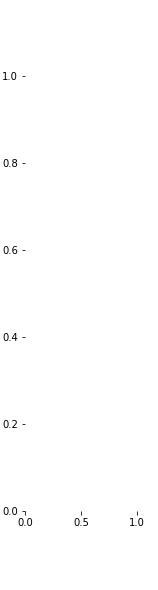

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from PIL import Image, ImageEnhance

# File path to the permeability data CSV
csv_file_path = '/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Clean Dataset/PERMnoheader_Krev.csv'

# Load and process data
permeability_data = pd.read_csv(csv_file_path, header=None)
permeability_data.columns = ['i', 'j', 'k', 'Perm']  # Changed to Perm

# Convert and clean data
permeability_data['i'] = pd.to_numeric(permeability_data['i'], errors='coerce')
permeability_data['j'] = pd.to_numeric(permeability_data['j'], errors='coerce')
permeability_data['k'] = pd.to_numeric(permeability_data['k'], errors='coerce')
permeability_data['Perm'] = pd.to_numeric(permeability_data['Perm'], errors='coerce')
permeability_data = permeability_data.dropna()

# Convert to integers for indices
permeability_data['i'] = permeability_data['i'].astype(int)
permeability_data['j'] = permeability_data['j'].astype(int)
permeability_data['k'] = permeability_data['k'].astype(int)
permeability_data['Perm'] = permeability_data['Perm'].replace(-99, np.nan)

# Get dimensions
max_i = permeability_data['i'].max() + 1
max_j = permeability_data['j'].max() + 1
max_k = permeability_data['k'].max() + 1

# Create and populate 3D array
permeability_cube = np.full((max_i, max_j, max_k), np.nan)
permeability_cube[permeability_data['i'], permeability_data['j'], permeability_data['k']] = permeability_data['Perm']

# Output directory
output_dir = "/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images"
os.makedirs(output_dir, exist_ok=True)

# Define custom colors for permeability (matching the reference image)
custom_colors = [
    '#FF0000',  # Red (high values)
    '#FFFF00',  # Yellow
    '#00FF00',  # Green
    '#00FFFF',  # Cyan
    '#0000FF',  # Blue
    '#FF00FF',  # Magenta (low values)
]
custom_cmap = ListedColormap(custom_colors)

# Increased upscale factor for higher resolution
upscale_factor = 8

def enhance_image(image):
    """Apply various enhancements to improve image quality"""
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(1.5)
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.2)
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.1)
    return image

# Save each layer as a high-resolution image
for layer in range(max_k):
    layer_data = permeability_cube[:, :, layer]

    # Skip empty layers
    if np.isnan(layer_data).all():
        continue
    
    # Apply logarithmic transformation
    min_val = np.nanmin(layer_data[layer_data > 0])  # Minimum non-zero value
    layer_data_log = np.log10(np.maximum(layer_data, min_val))
    
    # Normalize the log-transformed data to [0, 1]
    normalized_data = (layer_data_log - np.nanmin(layer_data_log)) / (np.nanmax(layer_data_log) - np.nanmin(layer_data_log))
    
    # Handle NaN values
    normalized_data = np.nan_to_num(normalized_data, nan=-1)
    
    # Create RGB image using custom colormap
    layer_rgb = custom_cmap(normalized_data)[:, :, :3]
    layer_rgb = (layer_rgb * 255).astype(np.uint8)
    
    # Set background for missing values
    background_mask = (normalized_data == -1)
    layer_rgb[background_mask] = [255, 255, 255]  # White background
    
    # Create initial image
    image = Image.fromarray(layer_rgb, mode="RGB")
    
    # Calculate new size for high resolution
    new_size = (image.width * upscale_factor, image.height * upscale_factor)
    
    # Resize with high-quality settings
    high_res_image = image.resize(new_size, Image.LANCZOS)
    
    # Apply image enhancements
    enhanced_image = enhance_image(high_res_image)
    
    # Save with high quality settings
    image_path = os.path.join(output_dir, f"Perm_layer_{layer}_ultra_high_res.png")
    enhanced_image.save(
        image_path,
        format='PNG',
        optimize=True,
        quality=95,
        dpi=(300, 300)
    )
    print(f"Saved ultra-high-resolution layer {layer} as {image_path}")

# Create and save colorbar legend
fig, ax = plt.subplots(figsize=(2, 8))
norm = mcolors.LogNorm(vmin=np.nanmin(permeability_data['Perm']), 
                      vmax=np.nanmax(permeability_data['Perm']))
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap),
                 cax=ax, label='Permeability (mD)')
cb.ax.set_ylabel('Permeability (mD)', rotation=270, labelpad=15)
plt.savefig(os.path.join(output_dir, 'permeability_legend.png'), 
            bbox_inches='tight', dpi=300)
plt.close()

Saved ultra-high-resolution layer 1 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_1_ultra_high_res.png
Saved ultra-high-resolution layer 2 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_2_ultra_high_res.png
Saved ultra-high-resolution layer 3 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_3_ultra_high_res.png
Saved ultra-high-resolution layer 4 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_4_ultra_high_res.png
Saved ultra-high-resolution layer 5 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_5_ultra_high_res.png
Saved ultra-high-resolution layer 6 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_6_ultra_high_res.png
Saved ultr

Saved ultra-high-resolution layer 51 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_51_ultra_high_res.png
Saved ultra-high-resolution layer 52 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_52_ultra_high_res.png
Saved ultra-high-resolution layer 53 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_53_ultra_high_res.png
Saved ultra-high-resolution layer 54 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_54_ultra_high_res.png
Saved ultra-high-resolution layer 55 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_55_ultra_high_res.png
Saved ultra-high-resolution layer 56 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_56_ultra_high_res.pn

Saved ultra-high-resolution layer 101 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_101_ultra_high_res.png
Saved ultra-high-resolution layer 102 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_102_ultra_high_res.png
Saved ultra-high-resolution layer 103 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_103_ultra_high_res.png
Saved ultra-high-resolution layer 104 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_104_ultra_high_res.png
Saved ultra-high-resolution layer 105 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_105_ultra_high_res.png
Saved ultra-high-resolution layer 106 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_106_ultra

Saved ultra-high-resolution layer 150 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_150_ultra_high_res.png
Saved ultra-high-resolution layer 151 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_151_ultra_high_res.png
Saved ultra-high-resolution layer 152 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_152_ultra_high_res.png
Saved ultra-high-resolution layer 153 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_153_ultra_high_res.png
Saved ultra-high-resolution layer 154 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_154_ultra_high_res.png
Saved ultra-high-resolution layer 155 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_155_ultra

Saved ultra-high-resolution layer 199 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_199_ultra_high_res.png
Saved ultra-high-resolution layer 200 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_200_ultra_high_res.png
Saved ultra-high-resolution layer 201 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_201_ultra_high_res.png
Saved ultra-high-resolution layer 202 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_202_ultra_high_res.png
Saved ultra-high-resolution layer 203 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_203_ultra_high_res.png
Saved ultra-high-resolution layer 204 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111/Perm_layer_204_ultra

ValueError: Invalid vmin or vmax

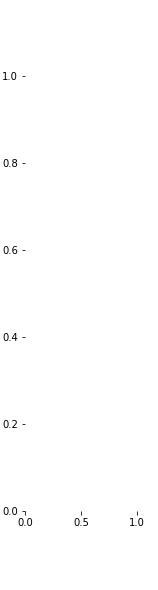

In [3]:
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# File path to the permeability data CSV
csv_file_path = '/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Clean Dataset/PERMnoheader_Krev.csv'

# Load and process data
permeability_data = pd.read_csv(csv_file_path, header=None)
permeability_data.columns = ['i', 'j', 'k', 'Perm']

# Convert and clean data
permeability_data['i'] = pd.to_numeric(permeability_data['i'], errors='coerce')
permeability_data['j'] = pd.to_numeric(permeability_data['j'], errors='coerce')
permeability_data['k'] = pd.to_numeric(permeability_data['k'], errors='coerce')
permeability_data['Perm'] = pd.to_numeric(permeability_data['Perm'], errors='coerce')
permeability_data = permeability_data.dropna()

# Convert to integers for indices
permeability_data['i'] = permeability_data['i'].astype(int)
permeability_data['j'] = permeability_data['j'].astype(int)
permeability_data['k'] = permeability_data['k'].astype(int)
permeability_data['Perm'] = permeability_data['Perm'].replace(-99, np.nan)

# Get dimensions
max_i = permeability_data['i'].max() + 1
max_j = permeability_data['j'].max() + 1
max_k = permeability_data['k'].max() + 1

# Create and populate 3D array
permeability_cube = np.full((max_i, max_j, max_k), np.nan)
permeability_cube[permeability_data['i'], permeability_data['j'], permeability_data['k']] = permeability_data['Perm']

# Output directory
output_dir = "/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_perm_layer_images111"
os.makedirs(output_dir, exist_ok=True)

# Define custom colors for permeability (updated to match the sample image)
custom_colors = [
    '#FF00FF',  # Magenta (low values)
    '#0000FF',  # Blue
    '#00FFFF',  # Cyan
    '#00FF00',  # Green
    '#FFFF00',  # Yellow
    '#FF0000',  # Red (high values)
]
custom_cmap = ListedColormap(custom_colors)

# Increase upscale factor for higher resolution
upscale_factor = 8

def enhance_image(image):
    """Apply various enhancements to improve image quality"""
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(1.5)
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.2)
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.1)
    return image

# Save each layer as a high-resolution image
for layer in range(max_k):
    layer_data = permeability_cube[:, :, layer]

    # Skip empty layers
    if np.isnan(layer_data).all():
        continue

    # Apply logarithmic transformation
    min_val = np.nanmin(layer_data[layer_data > 0])  # Minimum non-zero value
    layer_data_log = np.log10(np.maximum(layer_data, min_val))

    # Normalize the log-transformed data to [0, 1]
    normalized_data = (layer_data_log - np.nanmin(layer_data_log)) / (np.nanmax(layer_data_log) - np.nanmin(layer_data_log))

    # Handle NaN values
    normalized_data = np.nan_to_num(normalized_data, nan=-1)

    # Create RGB image using custom colormap
    layer_rgb = custom_cmap(normalized_data)[:, :, :3]
    layer_rgb = (layer_rgb * 255).astype(np.uint8)

    # Set background for missing values
    background_mask = (normalized_data == -1)
    layer_rgb[background_mask] = [0, 0, 0]  # Black background

    # Create initial image
    image = Image.fromarray(layer_rgb, mode="RGB")

    # Calculate new size for high resolution
    new_size = (image.width * upscale_factor, image.height * upscale_factor)

    # Resize with high-quality settings
    high_res_image = image.resize(new_size, Image.LANCZOS)

    # Apply image enhancements
    enhanced_image = enhance_image(high_res_image)

    # Save with high-quality settings
    image_path = os.path.join(output_dir, f"Perm_layer_{layer}_ultra_high_res.png")
    enhanced_image.save(
        image_path,
        format='PNG',
        optimize=True,
        quality=95,
        dpi=(300, 300)
    )
    print(f"Saved ultra-high-resolution layer {layer} as {image_path}")

# Create and save colorbar legend
fig, ax = plt.subplots(figsize=(2, 8))
norm = mcolors.LogNorm(vmin=np.nanmin(permeability_data['Perm']), vmax=np.nanmax(permeability_data['Perm']))
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax, label='Permeability (mD)')
cb.ax.set_ylabel('Permeability (mD)', rotation=270, labelpad=15)
plt.savefig(os.path.join(output_dir, 'permeability_legend.png'), bbox_inches='tight', dpi=300)
plt.close()


# Porosity

In [5]:
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# File path to the porosity data CSV
csv_file_path = '/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Clean Dataset/POROnoheader_Krevmodified.csv'

# Load and process data
porosity_data = pd.read_csv(csv_file_path, header=None)
porosity_data.columns = ['i', 'j', 'k', 'Porosity']

# Convert and clean data
porosity_data['i'] = pd.to_numeric(porosity_data['i'], errors='coerce')
porosity_data['j'] = pd.to_numeric(porosity_data['j'], errors='coerce')
porosity_data['k'] = pd.to_numeric(porosity_data['k'], errors='coerce')
porosity_data['Porosity'] = pd.to_numeric(porosity_data['Porosity'], errors='coerce')
porosity_data = porosity_data.dropna()

# Convert to integers for indices
porosity_data['i'] = porosity_data['i'].astype(int)
porosity_data['j'] = porosity_data['j'].astype(int)
porosity_data['k'] = porosity_data['k'].astype(int)
porosity_data['Porosity'] = porosity_data['Porosity'].replace(-99, np.nan)

# Get dimensions
max_i = porosity_data['i'].max() + 1
max_j = porosity_data['j'].max() + 1
max_k = porosity_data['k'].max() + 1

# Create and populate 3D array
porosity_cube = np.full((max_i, max_j, max_k), np.nan)
porosity_cube[porosity_data['i'], porosity_data['j'], porosity_data['k']] = porosity_data['Porosity']

# Output directory
output_dir = "/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images"
os.makedirs(output_dir, exist_ok=True)

# Define custom colors for porosity (based on the attached legend)
custom_colors = [
    '#0000FF',  # Blue (low values)
    '#00FFFF',  # Cyan
    '#00FF00',  # Green
    '#FFFF00',  # Yellow
    '#FF7F00',  # Orange
    '#FF0000',  # Red (high values)
]
custom_cmap = ListedColormap(custom_colors)

# Increase upscale factor for higher resolution
upscale_factor = 8

def enhance_image(image):
    """Apply various enhancements to improve image quality"""
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(1.5)
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.2)
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.1)
    return image

# Save each layer as a high-resolution image
for layer in range(max_k):
    layer_data = porosity_cube[:, :, layer]

    # Skip empty layers
    if np.isnan(layer_data).all():
        continue

    # Normalize the data to [0, 1]
    normalized_data = (layer_data - np.nanmin(layer_data)) / (np.nanmax(layer_data) - np.nanmin(layer_data))

    # Handle NaN values
    normalized_data = np.nan_to_num(normalized_data, nan=-1)

    # Create RGB image using custom colormap
    layer_rgb = custom_cmap(normalized_data)[:, :, :3]
    layer_rgb = (layer_rgb * 255).astype(np.uint8)

    # Set background for missing values
    background_mask = (normalized_data == -1)
    layer_rgb[background_mask] = [0, 0, 0]  # Black background

    # Create initial image
    image = Image.fromarray(layer_rgb, mode="RGB")

    # Calculate new size for high resolution
    new_size = (image.width * upscale_factor, image.height * upscale_factor)

    # Resize with high-quality settings
    high_res_image = image.resize(new_size, Image.LANCZOS)

    # Apply image enhancements
    enhanced_image = enhance_image(high_res_image)

    # Save with high-quality settings
    image_path = os.path.join(output_dir, f"Poro_layer_{layer}_ultra_high_res.png")
    enhanced_image.save(
        image_path,
        format='PNG',
        optimize=True,
        quality=95,
        dpi=(300, 300)
    )
    print(f"Saved ultra-high-resolution layer {layer} as {image_path}")

# Create and save colorbar legend
fig, ax = plt.subplots(figsize=(2, 8))
norm = mcolors.Normalize(vmin=np.nanmin(porosity_data['Porosity']), vmax=np.nanmax(porosity_data['Porosity']))
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax, label='Porosity (v/v)')
cb.ax.set_ylabel('Porosity (v/v)', rotation=270, labelpad=15)
plt.savefig(os.path.join(output_dir, 'porosity_legend.png'), bbox_inches='tight', dpi=300)
plt.close()


Saved ultra-high-resolution layer 1 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_1_ultra_high_res.png
Saved ultra-high-resolution layer 2 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_2_ultra_high_res.png
Saved ultra-high-resolution layer 3 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_3_ultra_high_res.png
Saved ultra-high-resolution layer 4 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_4_ultra_high_res.png
Saved ultra-high-resolution layer 5 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_5_ultra_high_res.png
Saved ultra-high-resolution layer 6 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_6_ultra_high_res.png
Saved ultra-high-resolution 

Saved ultra-high-resolution layer 52 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_52_ultra_high_res.png
Saved ultra-high-resolution layer 53 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_53_ultra_high_res.png
Saved ultra-high-resolution layer 54 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_54_ultra_high_res.png
Saved ultra-high-resolution layer 55 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_55_ultra_high_res.png
Saved ultra-high-resolution layer 56 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_56_ultra_high_res.png
Saved ultra-high-resolution layer 57 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_57_ultra_high_res.png
Saved ultra-high

Saved ultra-high-resolution layer 102 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_102_ultra_high_res.png
Saved ultra-high-resolution layer 103 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_103_ultra_high_res.png
Saved ultra-high-resolution layer 104 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_104_ultra_high_res.png
Saved ultra-high-resolution layer 105 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_105_ultra_high_res.png
Saved ultra-high-resolution layer 106 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_106_ultra_high_res.png
Saved ultra-high-resolution layer 107 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_107_ultra_high_res.png
Save

Saved ultra-high-resolution layer 152 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_152_ultra_high_res.png
Saved ultra-high-resolution layer 153 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_153_ultra_high_res.png
Saved ultra-high-resolution layer 154 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_154_ultra_high_res.png
Saved ultra-high-resolution layer 155 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_155_ultra_high_res.png
Saved ultra-high-resolution layer 156 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_156_ultra_high_res.png
Saved ultra-high-resolution layer 157 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_157_ultra_high_res.png
Save

Saved ultra-high-resolution layer 202 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_202_ultra_high_res.png
Saved ultra-high-resolution layer 203 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_203_ultra_high_res.png
Saved ultra-high-resolution layer 204 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_204_ultra_high_res.png
Saved ultra-high-resolution layer 205 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_205_ultra_high_res.png
Saved ultra-high-resolution layer 206 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_206_ultra_high_res.png
Saved ultra-high-resolution layer 207 as /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_poro_layer_images/Poro_layer_207_ultra_high_res.png
Save

# Vshale

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# File path to the Vsh data CSV
csv_file_path = '/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Clean Dataset/VSHnoheader_Krev.csv'

# Load and process data
vsh_data = pd.read_csv(csv_file_path, header=None)
vsh_data.columns = ['i', 'j', 'k', 'Vsh']

# Convert and clean data
vsh_data['i'] = pd.to_numeric(vsh_data['i'], errors='coerce')
vsh_data['j'] = pd.to_numeric(vsh_data['j'], errors='coerce')
vsh_data['k'] = pd.to_numeric(vsh_data['k'], errors='coerce')
vsh_data['Vsh'] = pd.to_numeric(vsh_data['Vsh'], errors='coerce')
vsh_data = vsh_data.dropna()

# Convert to integers for indices
vsh_data['i'] = vsh_data['i'].astype(int)
vsh_data['j'] = vsh_data['j'].astype(int)
vsh_data['k'] = vsh_data['k'].astype(int)
vsh_data['Vsh'] = vsh_data['Vsh'].replace(-99, np.nan)

# Get dimensions
max_i = vsh_data['i'].max() + 1
max_j = vsh_data['j'].max() + 1
max_k = vsh_data['k'].max() + 1

# Create and populate 3D array
vsh_cube = np.full((max_i, max_j, max_k), np.nan)
vsh_cube[vsh_data['i'], vsh_data['j'], vsh_data['k']] = vsh_data['Vsh']

# Output directory
output_dir = "/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_vsh_layer_images"
os.makedirs(output_dir, exist_ok=True)

# Define custom colors for Vsh (based on the attached legend)
custom_colors = [
    '#FFFF00',  # Yellow (low values)
    '#FFD700',  # Golden Yellow
    '#FFA500',  # Orange
    '#8B4513',  # Brown (high values)
]
custom_cmap = ListedColormap(custom_colors)

# Increase upscale factor for higher resolution
upscale_factor = 8

def enhance_image(image):
    """Apply various enhancements to improve image quality"""
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(1.5)
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.2)
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.1)
    return image

# Save each layer as a high-resolution image
for layer in range(max_k):
    layer_data = vsh_cube[:, :, layer]

    # Skip empty layers
    if np.isnan(layer_data).all():
        continue

    # Normalize the data to [0, 1]
    normalized_data = (layer_data - np.nanmin(layer_data)) / (np.nanmax(layer_data) - np.nanmin(layer_data))

    # Handle NaN values
    normalized_data = np.nan_to_num(normalized_data, nan=-1)

    # Create RGB image using custom colormap
    layer_rgb = custom_cmap(normalized_data)[:, :, :3]
    layer_rgb = (layer_rgb * 255).astype(np.uint8)

    # Set background for missing values
    background_mask = (normalized_data == -1)
    layer_rgb[background_mask] = [0, 0, 0]  # Black background

    # Create initial image
    image = Image.fromarray(layer_rgb, mode="RGB")

    # Calculate new size for high resolution
    new_size = (image.width * upscale_factor, image.height * upscale_factor)

    # Resize with high-quality settings
    high_res_image = image.resize(new_size, Image.LANCZOS)

    # Apply image enhancements
    enhanced_image = enhance_image(high_res_image)

    # Save with high-quality settings
    image_path = os.path.join(output_dir, f"Vsh_layer_{layer}_ultra_high_res.png")
    enhanced_image.save(
        image_path,
        format='PNG',
        optimize=True,
        quality=95,
        dpi=(300, 300)
    )
    print(f"Saved ultra-high-resolution layer {layer} as {image_path}")

# Create and save colorbar legend
fig, ax = plt.subplots(figsize=(2, 8))
norm = mcolors.Normalize(vmin=np.nanmin(vsh_data['Vsh']), vmax=np.nanmax(vsh_data['Vsh']))
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax, label='Vsh (fraction)')
cb.ax.set_ylabel('Vsh (fraction)', rotation=270, labelpad=15)
plt.savefig(os.path.join(output_dir, 'vsh_legend.png'), bbox_inches='tight', dpi=300)
plt.close()


# Sw

In [1]:
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# File path to the Sw data CSV
csv_file_path = '/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Clean Dataset/SKrevs_wnoheader.csv'

# Load and process data
sw_data = pd.read_csv(csv_file_path, header=None)
sw_data.columns = ['i', 'j', 'k', 'Sw']

# Convert and clean data
sw_data['i'] = pd.to_numeric(sw_data['i'], errors='coerce')
sw_data['j'] = pd.to_numeric(sw_data['j'], errors='coerce')
sw_data['k'] = pd.to_numeric(sw_data['k'], errors='coerce')
sw_data['Sw'] = pd.to_numeric(sw_data['Sw'], errors='coerce')
sw_data = sw_data.dropna()

# Convert to integers for indices
sw_data['i'] = sw_data['i'].astype(int)
sw_data['j'] = sw_data['j'].astype(int)
sw_data['k'] = sw_data['k'].astype(int)
sw_data['Sw'] = sw_data['Sw'].replace(-99, np.nan)

# Get dimensions
max_i = sw_data['i'].max() + 1
max_j = sw_data['j'].max() + 1
max_k = sw_data['k'].max() + 1

# Create and populate 3D array
sw_cube = np.full((max_i, max_j, max_k), np.nan)
sw_cube[sw_data['i'], sw_data['j'], sw_data['k']] = sw_data['Sw']

# Output directory
output_dir = "/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/orginal_sw_layer_images"
os.makedirs(output_dir, exist_ok=True)

# Define custom colors for Sw (based on the attached legend)
custom_colors = [
    '#FF0000',  # Red (low values)
    '#FFA500',  # Orange
    '#FFFF00',  # Yellow
    '#00FF00',  # Green
    '#00FFFF',  # Cyan
    '#0000FF',  # Blue (high values)
]
custom_cmap = ListedColormap(custom_colors)

# Increase upscale factor for higher resolution
upscale_factor = 8

def enhance_image(image):
    """Apply various enhancements to improve image quality"""
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(1.5)
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.2)
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.1)
    return image

# Save each layer as a high-resolution image
for layer in range(max_k):
    layer_data = sw_cube[:, :, layer]

    # Skip empty layers
    if np.isnan(layer_data).all():
        continue

    # Normalize the data to [0, 1]
    normalized_data = (layer_data - np.nanmin(layer_data)) / (np.nanmax(layer_data) - np.nanmin(layer_data))

    # Handle NaN values
    normalized_data = np.nan_to_num(normalized_data, nan=-1)

    # Create RGB image using custom colormap
    layer_rgb = custom_cmap(normalized_data)[:, :, :3]
    layer_rgb = (layer_rgb * 255).astype(np.uint8)

    # Set background for missing values
    background_mask = (normalized_data == -1)
    layer_rgb[background_mask] = [0, 0, 0]  # Black background

    # Create initial image
    image = Image.fromarray(layer_rgb, mode="RGB")

    # Calculate new size for high resolution
    new_size = (image.width * upscale_factor, image.height * upscale_factor)

    # Resize with high-quality settings
    high_res_image = image.resize(new_size, Image.LANCZOS)

    # Apply image enhancements
    enhanced_image = enhance_image(high_res_image)

    # Save with high-quality settings
    image_path = os.path.join(output_dir, f"Sw_layer_{layer}_ultra_high_res.png")
    enhanced_image.save(
        image_path,
        format='PNG',
        optimize=True,
        quality=95,
        dpi=(300, 300)
    )
    print(f"Saved ultra-high-resolution layer {layer} as {image_path}")

# Create and save colorbar legend
fig, ax = plt.subplots(figsize=(2, 8))
norm = mcolors.Normalize(vmin=np.nanmin(sw_data['Sw']), vmax=np.nanmax(sw_data['Sw']))
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax, label='Water Saturation (Sw)')
cb.ax.set_ylabel('Water Saturation (Sw)', rotation=270, labelpad=15)
plt.savefig(os.path.join(output_dir, 'sw_legend.png'), bbox_inches='tight', dpi=300)
plt.close()


/home/g202103050/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.